# Demo VirtualHome

This is a demo of how to run VirtualHome UnitySimulator. The demo will walk though how to start an environment and visualize it, how to prepare it to perform activities and finally how to perform activities in them.

<img src=https://raw.githubusercontent.com/xavierpuigf/virtualhome_unity/master/doc/assets/banner.gif />



# Setup
The code below is only needed if you are running the demo in colab. It installs a package to stream content on Google Colab.

**Note:** Make sure you have GPU enabled if you are running in colab. 

Select Runtime > Change runtime type > Hardware accelerator: GPU


In [ ]:
import os
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    osname = "linux"
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
    # Clone VirtualHome
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd /content/virtualhome
    !pip install -r requirements.txt
else:
    %cd ..
    from sys import platform
    if platform == "darwin":
        osname = "macos"
    elif platform == "linux":
        osname = "linux"
    elif platform == "windows" or platform == 'win32':
        osname = "windows"

## Download the simulator

In [ ]:
if not os.path.isfile(f"{osname}_exec.zip"):
    ! wget http://virtual-home.org/release/simulator/v2.0/v2.3.0/linux_exec.zip
    ! unzip -q linux_exec.zip
%cd demo

# Imports

In [1]:
%matplotlib notebook
import IPython.display
import glob
from utils_demo import *
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

#import virtualhome
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

# Starting communication

The first step is to start a communication with the simulator. Make sure before you run this that you have downloaded the simulator, and placed it under the `simulation` folder. You will be interacting with the simulator with the communication `comm` created here. You can include the file name of the simulator or just call `UnityCommunication()` and manually open the executable.

Select `manual` if you are opening the executable separately, and `auto` if the unity executable is still not open.

Remember that if you are running this in a headless server, you will need to start a display in a separate terminal using: 

```
sudo python helper_scripts/startx $DISPLAY_NUM
```

This is not needed if you are running a colab notebook.

In [8]:
mode = 'manual' # auto / manual
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../macos_exec*'
    else:
        exec_file = '../linux_exec*.x86_64'
    file_names = glob.glob(exec_file)
    if len(file_names) > 0:
        file_name = file_names[0]
        comm = UnityCommunication(file_name=file_name, port="8082", x_display="0")
    else:
        print("Error: executable path not found.")
else:
    comm = UnityCommunication()

# Starting and Visualizing Scenes

After initalizing the simulation. We can interact with the environments provided in VirtualHome. The simulator is composed of 50 human designed apartments, a sample of environments can be seen here.

100%|██████████| 10/10 [00:10<00:00,  1.02it/s]


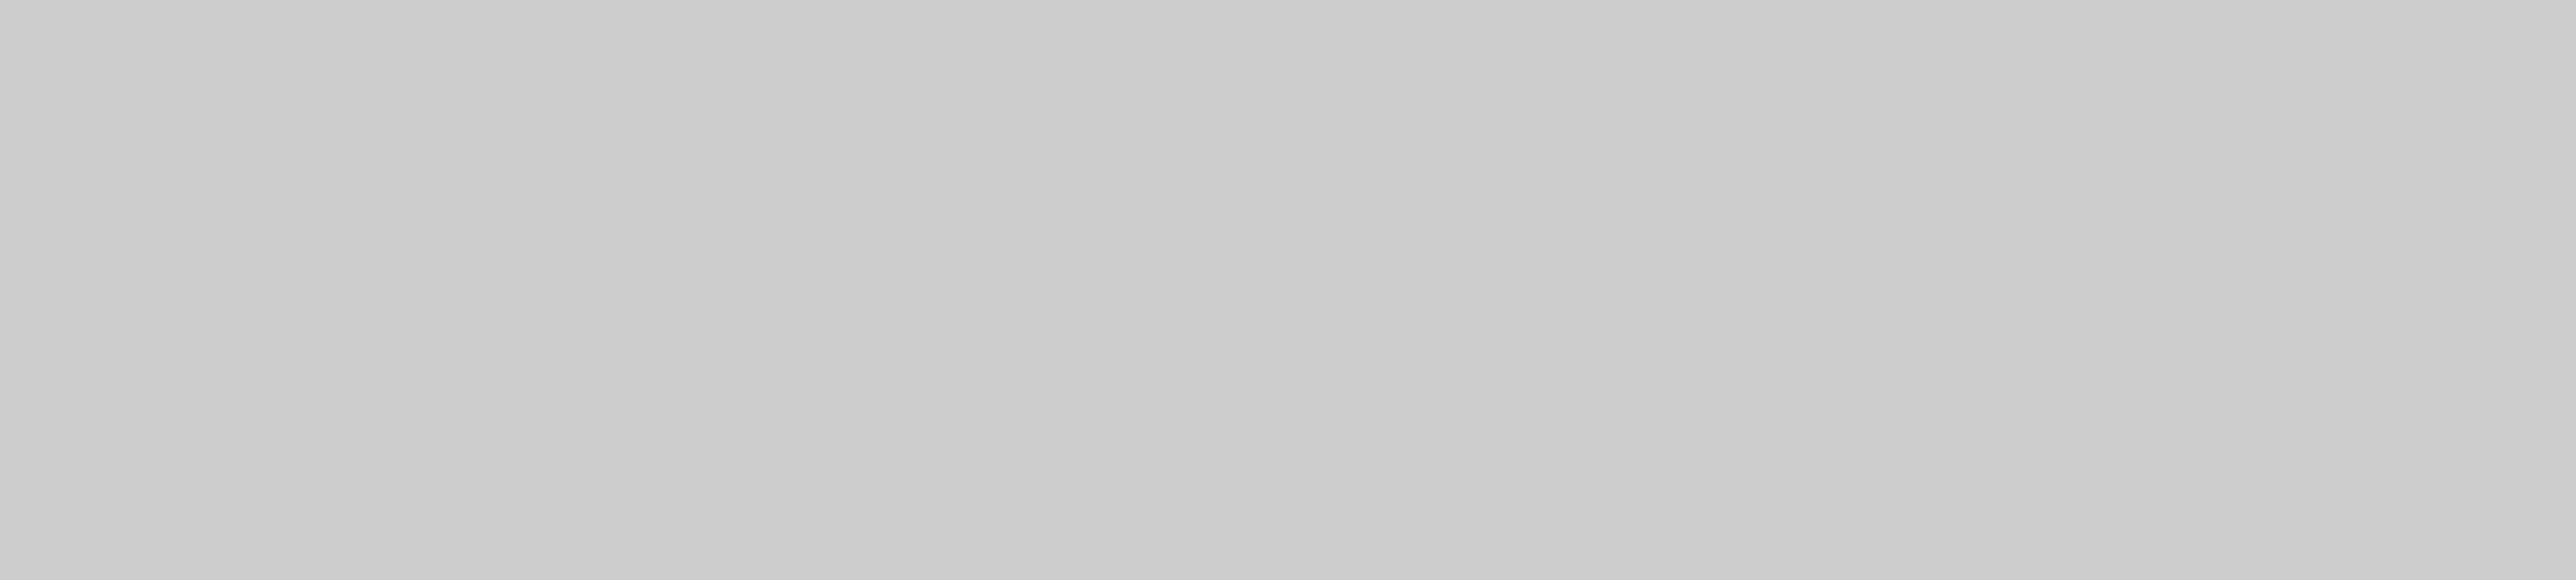

In [9]:
# The environments are numbered 0 to 50, let's visualize a few
views = []
for scene_id in tqdm(range(10)):
    comm.reset(scene_id)
    
    # We will go over the line below later
    comm.remove_terrain()
    top_view = get_scene_cameras(comm, [-1])
    views += top_view
    
IPython.display.display(display_grid_img(views, nrows=2))

# Procedural Generation

VirtualHome also has support for procedural generation where we can generate completely new environments during runtime.

In [ ]:
views = []
for proc_gen_seed in tqdm(range(10)):
    comm.procedural_generation(proc_gen_seed)
    
    # We will go over the line below later
    comm.remove_terrain()
    top_view = get_scene_cameras(comm, [-1])
    views += top_view
    
IPython.display.display(display_grid_img(views, nrows=2)) 

## Scene start and display

We will start scene number 4 and visualize it from different views. We start it by calling reset. Scenes are numbered from 0 to 49.

In [ ]:
comm.reset(0)

Each scene has multiple cameras, we will take screenshots for some of the cameras in this scene, specified by indices.

In [ ]:
indices = [3, 32, -5, -1, -20, 15, 48, -8, 50, 17]
img_final = display_scene_cameras(comm, indices, nrows=2)
IPython.display.display(img_final)

## VirtualHome supports multiple modalities

The cameras can also display other modalities, such as semantic segmentation, depth, instance segmentation or optical flow when playing videos. We will display a few of those here.

In [ ]:
indices = [-20, 1, 48, -8, 17]
img_final = display_scene_modalities(
    comm, 
    indices, 
    modalities=['normal', 'seg_class', 'seg_inst', 'depth', 'surf_normals'], nrows=5)
IPython.display.display(img_final)

## Including cameras

You can also add new cameras in the scene and get screenshots from those

In [ ]:
# specify the position and rotation of the camera
comm.add_camera(position=[-3,1.8,-4], rotation=[20, 120, 0], field_view=60)

# Get the last camera
s, c = comm.camera_count()
img_final = display_scene_cameras(comm, [c-1], nrows=1)
IPython.display.display(img_final)

We can also update existing cameras, here we will update the camera we just added

In [ ]:
# specify the position and rotation of the camera
comm.update_camera(c-1, position=[-3,1.8,-4], rotation=[20, 120, 0], field_view=80)

# Get the last camera
s, c = comm.camera_count()
img_final = display_scene_cameras(comm, [c-1], nrows=1)
IPython.display.display(img_final)

## Visualizing the scene as a graph

Each scene in VirtualHome can be visualized as a graph, allowing to query the objects appearing, and their relationships. We start by obtaining the graph from the current scene.

In [ ]:
s, graph = comm.environment_graph()

The graph is a dictionary with `nodes` and `edges`. Each node corresponds to an object and contains information such as.
- class_name: the object_name
- states: in which state the object is
- id: a number you can use to perform actions over the object 

Let's print one of the nodes, to see more of the information

In [ ]:
graph['nodes'][140]

The edges connect object ids with spatial relationships, such as `INSIDE`, `ON`, `CLOSE`. You can check more of them in the `simulation` folder.

In [ ]:
graph['edges'][:5]

The graph also contains bounding box and center information, which may be useful to reason about the environment layout.

# Modifying your environment and preparing for activities

In the previous section we viewed how to read and visualize the environment. Now we are interested in modifying the environment to perform activities in them. 

## Get default environment

All the environments have a default setting. We can go to this setting by calling reset()

In [ ]:
comm.reset(4)

## Adding Objects

We will start by adding objects to interact with in the environments. We can start by adding a cat in the environment.

### Adding a cat

We first want to make sure that the cat will be added in the current environment. Let's say that we want to add it in one of the sofas.

In [ ]:
imgs_prev = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev, nrows=1)

We start by reading the graph and looking for one of the sodas in the scene.

In [ ]:
success, graph = comm.environment_graph();
sofa = find_nodes(graph, class_name='sofa')[-2]
print(sofa)

We now add one node with id `1000` of type cat, and an edge between the sofa node and the cat, specifying that the cat should be on the sofa.

In [ ]:
add_node(graph, {'class_name': 'cat', 
                   'category': 'Animals', 
                   'id': 1000, 
                   'properties': [], 
                   'states': []})
add_edge(graph, 1000, 'ON', sofa['id'])

#### Update environment

The graph is now updated, but now we have to call the simulator so that the environment gets updated with the graph. Let's do it.

In [ ]:
success, message = comm.expand_scene(graph)

You can now take an image of the environment, you will see how there has been a cat added in the environment

In [ ]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

In [ ]:
imgs_prev = imgs_final

### Opening fridge

We may not want to add any new object, but just to change the state of the current objects. We can do this very similarly, by changing the environment graph. Let's say we want to open the fridge.

We read again the graph

In [ ]:
success, graph = comm.environment_graph();

We find the node `fridge` and change its `states` to open. 

In [ ]:
fridge = find_nodes(graph, class_name='fridge')[0]

In [ ]:
fridge['states'] = ['OPEN']

We finally expand the graph, as we did before.

In [ ]:
success = comm.expand_scene(graph)

In [ ]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

### Appliances

We will use the same method as before to change the state of some appliances. Again just by modifying the state of the graph.

We take a picture of the apartment to see how it looks before doing any change

In [ ]:
indices = [0]
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=1)

We now get the graph of the environment, and select a TV and a light

In [ ]:
success, graph = comm.environment_graph()
prev_graph = graph
tv_node = [x for x in graph['nodes'] if x['class_name'] == 'tv'][0]
light_node = [x for x in graph['nodes'] if x['class_name'] == 'lightswitch'][0]

We change the state and modify the scene with the new graph.

In [ ]:
tv_node['states'] = ['ON']
light_node['states'] = ['OFF']
_ = comm.expand_scene(graph)
last_graph = graph

We visualize the final scene

In [ ]:
imgs_final = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev+imgs_final, nrows=1)

### Setting up time

VirtualHome also includes a real-time management system based on the 24 hour system and assign tasks to agents depending on the time of day. Furthermore the time also affects the sun's position in the sky which has a direct effect on the outdoor lighting and indoor lighting through the windows.

In [ ]:
comm.reset(2)

In [ ]:
views = []
s, message = comm.add_camera(position=[-9.2,1.3,-3], rotation=[15, 130, 0], field_view=60)
cam_id = int(message.split(':')[1])
# Set time to 05:30 
comm.set_time(hours=10, minutes=30, seconds=0)
morning_view = get_scene_cameras(comm, [cam_id])
views += morning_view

# Set time to 8:30 
comm.set_time(hours=15, minutes=30, seconds=0)
day_view = get_scene_cameras(comm, [cam_id])
views += day_view

# Set time to 21:00 
comm.set_time(hours=21, minutes=0, seconds=0)
night_view = get_scene_cameras(comm, [cam_id])
views += night_view
    
IPython.display.display(display_grid_img(views, nrows=1)) 

We can also deactivate the time and the forests outside, if we want

In [ ]:
comm.reset(0)
comm.remove_terrain()
no_day_view = get_scene_cameras(comm, [17])
IPython.display.display(display_grid_img(no_day_view, nrows=1)) 

# Generating Scripts

We now can start scenes, visualize them and modify them. The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the `id` of each of the nodes in the environment graph.

You can check the list of actions currently implemented [here](https://github.com/xavierpuigf/virtualhome/tree/master/simulation#actions)

### Adding a character

The first step is to add agents in the environment, that will be performing the activity. You can specify which agent you want to add and the room where you want to add it

In [ ]:
comm.reset(4)
tv_node['states'] = ['OFF']
comm.expand_scene(prev_graph)
comm.add_character('chars/Female2', initial_room='kitchen')
s, g = comm.environment_graph()
cat_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'cat'][0]


If you count the number of cameras, you will see that a few new cameras have been added into the scene. These are cameras attached to the character. When the character moves, the cameras will move as well.

In [ ]:
s, nc = comm.camera_count()
indices = range(nc - 6, nc)
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=2)

## Generating the first script

Let's start by interacting witht the cat and the sofa that we set up before. The cat had id 1000. The sofa was stored in a variable `sofa` containing that node. We can query its id directly. This sequence will make the agent walk to the sofa, grab the cat and sit in the sofa.

In [ ]:
script = ['<char0> [Walk] <sofa> ({})'.format(sofa['id']),
          '<char0> [Find] <cat> ({})'.format(cat_id),
          '<char0> [Grab] <cat> ({})'.format(cat_id),
          '<char0> [Sit] <sofa> ({})'.format(sofa['id'])]


We now want to execute the script in the environment. We do that through render_script. Notice that we can specify a file name, which will be used to save a video with the activity.

In [ ]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_width=320,
                                      image_height=240,  
                                      skip_animation=False,
                                      recording=True,
                                      save_pose_data=True,
                                      file_name_prefix='relax')



This saves the frames of the video into the `Output/relax` folder, which should be where you had your executable. Let's generate a video from the frames.

In [ ]:
# Enter here the path to the video, it should be in the same location where you stored your executable 
path_video = "./Output/"
utils_viz.generate_video(input_path=path_video, prefix='relax', output_path='.')

In [ ]:
display_vid('./video_normal.mp4')

Other paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [ ]:
# We can also visualize the skeleton

path_video = "./Output/"
pose_char, frames = utils_viz.get_skeleton(input_path=path_video, prefix='relax')
ax = plt.axes(projection='3d')
frame = 40
center_char = pose_char.mean(1)
ax.scatter3D(pose_char[frame, :, 0], pose_char[frame, :, 2], pose_char[frame, :, 1])
ax.set_xlim(center_char[frame, 0]-0.8, center_char[frame, 0] + 0.8)
ax.set_ylim(center_char[frame, 2]-0.8, center_char[frame, 2] + 0.8)

## Generating a script without a video

In some occasions you may not be interested in generating a full video for the script, for example if you want to do RL. You can run the script withtout rendering a video by setting image_synthesis to empty. This will execute the script much more quickly

Restart the previous graph

In [ ]:
comm.reset(4)
comm.expand_scene(prev_graph)
comm.add_character()
s, g = comm.environment_graph()

Run with `image_synthesis=[]`

In [ ]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_synthesis=[])

## Generating from multiple views

We can chose which camera to use while rendering the videos. This is done through the flag `CAMERA_MODE`.

In [ ]:
comm.reset(4)
_, _ = comm.expand_scene(last_graph)
comm.add_character()
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      recording=True,
                                      image_synthesis=['normal'],
                                      file_name_prefix='multiview',
                                      camera_mode=['FIRST_PERSON', 'PERSON_TOP'])

You can specify camera names, for cameras that will follow the character or camera indices, for static cameras. To get the list of camera names, call character_cameras:

In [ ]:
comm.character_cameras()[1]

## Generating underspecified videos

If we do not care which objects the simulator should interact with, we can also let it decide. If we use the flag `find_solution=True` we can start enumerating objects by `1` instead of following the graph ids. Unity will try to find a solution. Note that if we want to interact with 2 objects of the same kind, they will need to have different ids (i.e. 1 and 2)

In [ ]:
comm.reset(0)

In [ ]:
s, g = comm.environment_graph()
[node for node in g['nodes'] if node['class_name'] == 'salmon']

In [ ]:
comm.add_character()

In [ ]:
script = ['<char0> [walk] <salmon> (1)',
          '<char0> [grab] <salmon> (1)',
          '<char0> [walk] <microwave> (1)',
          '<char0> [open] <microwave> (1)',
          '<char0> [putin] <salmon> (1) <microwave> (1)',
          '<char0> [close] <microwave> (1)',
          '<char0> [switchon] <microwave> (1)']
          
success, message = comm.render_script(script=script, 
                                      find_solution=True,
                                      processing_time_limit=80,
                                      frame_rate=15,
                                      image_width=512, image_height=320,
                                      skip_animation=False,
                                      image_synthesis=['normal'],
                                      camera_mode=['PERSON_FROM_BACK'],
                                      recording=True,
                                      file_name_prefix='milk')

# Multi-agent Actions

You can also generate actions with multiple agents in them, simply add more agents, and specify which agents should do which action

In [ ]:
# Reset the scene
comm.reset(0)
s, g = comm.environment_graph()
# Add two agents this time
comm.add_character('Chars/Male2', initial_room='kitchen')
comm.add_character('Chars/Female4', initial_room='bedroom')

# Get nodes for salmon and microwave, glass, faucet and sink
salmon_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'salmon'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
glass_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'waterglass'][-1]
sink_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sink'][0]
faucet_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'faucet'][-1]


# Put salmon in microwave
script = [
    '<char0> [walk] <salmon> ({}) | <char1> [walk] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [grab] <salmon> ({}) | <char1> [grab] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [open] <microwave> ({}) | <char1> [walk] <sink> ({})'.format(microwave_id, sink_id),
    '<char0> [putin] <salmon> ({}) <microwave> ({}) | <char1> [putback] <glass> ({}) <sink> ({})'.format(salmon_id, microwave_id, glass_id, sink_id),
    '<char0> [close] <microwave> ({}) | <char1> [switchon] <faucet> ({})'.format(microwave_id, faucet_id)
]
comm.render_script(script, frame_rate=10, camera_mode=["PERSON_FROM_BACK"], recording=True)

# Interactive agents


So far we have seen how to generate videos, but we can use the same command to deploy or train agents in the environment. You can execute the previous instructions one by one, and get an observation or graph at every step. or that, you don't need to generate videos or have animations, since it will slow down your agents. Use `skip_animation=True` to generate actions without animating them. Remember to turn off the recording mode as well.

In [ ]:
# Reset the scene
comm.reset(0)

# Add two agents this time
comm.add_character('Chars/Male2', initial_room='kitchen')
comm.add_character('Chars/Female4', initial_room='bedroom')

# Get nodes for salmon and microwave, glass, faucet and sink
salmon_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'salmon'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
glass_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'waterglass'][-1]
sink_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sink'][0]
faucet_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'faucet'][-1]


# Put salmon in microwave
script = [
    '<char0> [walk] <salmon> ({}) | <char1> [walk] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [grab] <salmon> ({}) | <char1> [grab] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [open] <microwave> ({}) | <char1> [walk] <sink> ({})'.format(microwave_id, sink_id),
    '<char0> [putin] <salmon> ({}) <microwave> ({}) | <char1> [putback] <glass> ({}) <sink> ({})'.format(salmon_id, microwave_id, glass_id, sink_id),
    '<char0> [close] <microwave> ({}) | <char1> [switchon] <faucet> ({})'.format(microwave_id, faucet_id)
]

s, cc = comm.camera_count()
images = []
for script_instruction in script:
    print(script_instruction)
    comm.render_script([script_instruction], recording=False, skip_animation=True)
    # Here you can get an observation, for instance
    s, im = comm.camera_image([cc-8], image_width=300, image_height=300)
    images.append(im[0])
    
display_grid_img(images, nrows=1)

# Finer control

We can also have finer control where objects go via action modifiers, the demo below shows how to place an object in different parts of the table

In [ ]:
comm.reset(0)
s, g = comm.environment_graph()
# Remove stuff from the table and add the character
table = [node for node in g['nodes'] if node['class_name'] == 'kitchentable'][0]
mouse = [node for node in g['nodes'] if node['class_name'] == 'mouse'][0]
mouse_id = mouse['id']
table_id = table['id']

objects_on_table = [edge['from_id'] for edge in g['edges'] 
                    if edge['to_id'] == table['id'] and edge['relation_type'] == 'ON']
new_graph = {
    'nodes': [node for node in g['nodes'] if node['id'] not in objects_on_table],
    'edges': [edge for edge in g['edges'] if edge['from_id'] not in objects_on_table and 
                                             edge['to_id'] not in objects_on_table]
}

comm.expand_scene(new_graph)
comm.add_character()

# This is to get a camera view on top of the character
cc = comm.camera_count()[1] - 7


# Start grabbing the mouse and go to the table
script1 = [f'<char0> [grab] <mouse> ({mouse_id})', 
           f'<char0> [walk] <kitchentable> ({table_id})']
s, m = comm.render_script(script1, skip_animation=True)

images = []

# Place the mouse in some position
posx, posy = -1.1, -5.5
script2 = [f'<char0> [putback] <mouse> ({mouse_id}) <kitchentable> ({table_id}) <position> {posx},{posy}']
s, m = comm.render_script(script2, skip_animation=True)
s, im1 = comm.camera_image([cc])
images.append(im1[0])

# Try a different positiom
posx, posy = -1.3, -5.1
script2 = [f'<char0> [grab] <mouse> ({mouse_id})',
           f'<char0> [putback] <mouse> ({mouse_id}) <kitchentable> ({table_id}) <position> {posx},{posy}']
s, m = comm.render_script(script2, skip_animation=True)
s, im1 = comm.camera_image([cc])
images.append(im1[0])

display_grid_img(images, nrows=1)


# Physics


VirtualHome is also able to simulate physics in the environments, and you can use the following api call to alter the gravitational force experienced in the environemnt. By activating physics, all objects behave as expected, just like in the real world. However you can also alter the "g-force" to make the agent feel like they are a astronaut in space.

In [ ]:
# Reset the scene and get the graph
comm.reset(0)
s, g = comm.environment_graph()

# Add a agent 
comm.add_character('Chars/female2', initial_room='kitchen')

# Get nodes for apple, desk, kitchen
apple = [node['id'] for node in g['nodes'] if node['class_name'] == 'apple'][0]
desk = [node['id'] for node in g['nodes'] if node['class_name'] == 'desk'][1]
kitchen = [node['id'] for node in g['nodes'] if node['class_name'] == 'kitchen'][0]


In [ ]:
# Activate gravity
comm.activate_physics()

In [ ]:
# Put apple on desk
script = [
          '<char0> [grab] <apple> ({})'.format(apple),
          '<char0> [put] <apple> ({}) <desk> ({})'.format(apple, desk),
          '<char0> [walk] <kitchen> ({})'.format(kitchen),
          '<char0> [grab] <apple> ({})'.format(apple),
          '<char0> [put] <apple> ({}) <desk> ({}  <position> 0,-3)'.format(apple, desk),
         ]
success, message = comm.render_script(script=script[:2], 
                                      find_solution=True,
                                      processing_time_limit=80,
                                      frame_rate=15,
                                      image_width=512, image_height=320,
                                      skip_animation=False,
                                      image_synthesis=['normal'],
                                      camera_mode=['58'],
                                      recording=True,
                                      file_name_prefix='gravity')

In [ ]:
path_video = "./Output/"
utils_viz.generate_video(input_path=path_video, prefix='gravity', output_path='.')
